# FRQI QAE
This notebook contains code for the FRQI-QAE Model.\
Inspired by [Romero et al](https://arxiv.org/pdf/1612.02806.pdf) and [Sim et al](https://arxiv.org/pdf/1810.10576.pdf).\
Developed by Filip Igic for his FYP.

In [51]:
import qiskit as qk
from qiskit import QuantumCircuit, Aer, IBMQ
from qiskit import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import plot_histogram
from math import pi
import matplotlib.pyplot as mpl

In [133]:
def frqi():
    on = pi/2 # white pixel
    qc = QuantumCircuit(3, name='FRQI')
    qc.h(0)
    qc.h(1)
    qc.x(0)
    qc.x(1)
    qc.cry(on,0,2)
    qc.cx(0,1)
    qc.cry(-on,1,2)
    qc.cx(0,1)
    qc.cry(on,1,2)
    qc.x(0)
    qc.x(1)
    return qc

def encode(x):
    qc = QuantumCircuit(3, name="Encode")
    qc.ry(x[0], 0)
    qc.ry(x[1], 1)
    qc.ry(x[2], 2)
    qc.cx(0, 1)
    qc.cx(0, 2)
    return qc

In [134]:
def f(x):
    qc = QuantumCircuit(3)

    qc.append(frqi(), qc.qubits[:3])

    qc.append(encode(x), qc.qubits[:3])

    qc.reset(1)
    qc.reset(2)

    qc.append(encode(x).inverse(), qc.qubits[:3])

    qc.append(frqi().inverse(), qc.qubits[:3])

    qc.measure_all()
    
    qasm_sim = Aer.get_backend('qasm_simulator')
    t_qc = transpile(qc, qasm_sim)
    qobj = assemble(t_qc, shots=4096)
    result = qasm_sim.run(qobj).result()
    counts = result.get_counts(qc)
    
    if '000' in counts:
        loss = counts['000']/4096
    else:
        loss = 0
    loss *= -1
    history.append(loss)
    return loss

Optimal parameters: [4.12021483 3.96165908 5.78171874], Loss: -0.83642578125


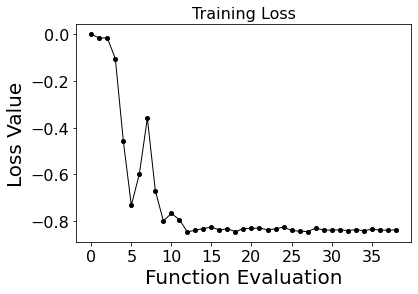

In [139]:
import scipy.optimize as sp

history=[] #history of losses through training

result = sp.minimize(f, [pi, pi, pi], method='COBYLA', constraints={'type': 'ineq', 'fun': lambda x: 2. * pi - x})

op=result.x #optimal parameters
print(f'Optimal parameters: {op}, Loss: {result.fun}')

fig = mpl.figure(figsize=(6, 4))
mpl.plot(history, 'ko-', markersize=4, linewidth=1)
mpl.title("Training Loss", fontsize=16)
mpl.xlabel("Function Evaluation",fontsize=20)
mpl.ylabel("Loss Value", fontsize=20)
mpl.xticks(fontsize=16)
mpl.yticks(fontsize=16)
mpl.show()

## Testing
Based on the optimal parameters found above, I will test them to see the quality of the image.

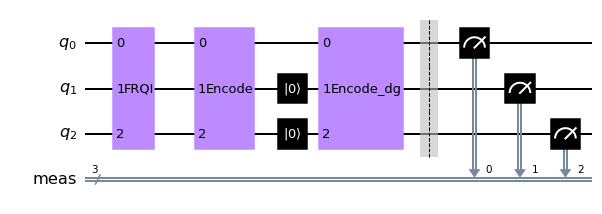

In [143]:
qc = QuantumCircuit(3)

qc.append(frqi(), qc.qubits[:3])

qc.append(encode(op), qc.qubits[:3])

qc.reset(1)
qc.reset(2)

qc.append(encode(op).inverse(), qc.qubits[:3])

qc.measure_all()

qc.draw('mpl')

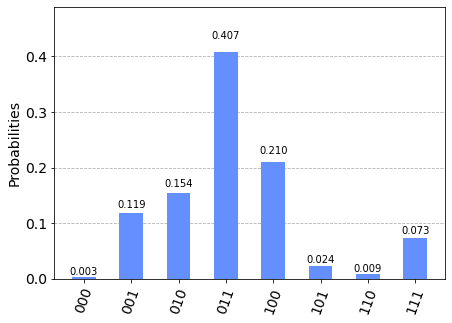

In [141]:
qasm_sim = Aer.get_backend('qasm_simulator')
t_qc = transpile(qc, qasm_sim)
qobj = assemble(t_qc, shots=4096)
result = qasm_sim.run(qobj).result()
counts = result.get_counts(qc)
plot_histogram(counts)

## Image Retrieval

[[0.9862700228832952, 0.1689419795221843], [0.05680119581464873, 0.1525165226232842]]


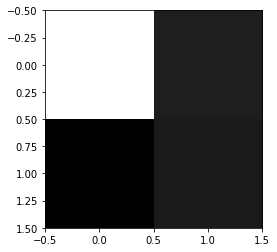

In [144]:
image=[[0, 0], [0, 0]]
count_sum=[[0, 0], [0, 0]]
for x in counts:
    if x[1:] == '00':
        count_sum[0][0]+=counts[x]
    elif x[1:] == '01':
        count_sum[0][1]+=counts[x]
    elif x[1:] == '10':
        count_sum[1][0]+=counts[x]
    elif x[1:] == '11':
        count_sum[1][1]+=counts[x]

for x in counts:
    if x[0] == '1':
        image[int(x[1])][int(x[2])]=counts[x]/count_sum[int(x[1])][int(x[2])]
        
print(image)
mpl.imshow(image, cmap='gray')